# Recursion Cellular Image Classification - fastai starter

Thanks greatly to [this kaggle kernel](https://www.kaggle.com/kernels/scriptcontent/20557703/download)

## Load modules

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from fastai.vision import *

In [2]:
print("GPU cuda:\t",torch.cuda.is_available())

GPU cuda:	 True


In [3]:
SIZE = 320
SITE = 1
BS = 16
MODEL_TYPE = "b3"
LOAD_NAME = "rcic-b3-s320-bs16-s12"
SAVE_NAME = "rcic-ps-%s-sz%s-bs%s-s%s"%(MODEL_TYPE,SIZE,BS,SITE)+""
print("learn save name",SAVE_NAME)

learn save name rcic-ps-b3-sz320-bs16-s1


In [4]:
SUB = Path("/home/hadoop/github/python4ml/experiments/rcic/submissions/")
PSEODO = SUB/"submission_ens_3b3_2b4.csv"

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

SEED = 0
seed_everything(SEED)

## Loading and formatting data

Here I will load the csv into the DataFrame, and create a column in the DataFrame with the path to the corresponding image (`generate_df`)

In [6]:
from pathlib import Path
print("Loading training dataframe")
DATA = Path("/mnt/disk4/cell/")

Loading training dataframe


In [30]:
train_df = pd.read_csv(DATA/'train.csv')
train_df.head(10)

,id_code,experiment,plate,well,sirna
0,HEPG2-01_1_B03,HEPG2-01,1,B03,513
1,HEPG2-01_1_B04,HEPG2-01,1,B04,840
2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020
3,HEPG2-01_1_B06,HEPG2-01,1,B06,254
4,HEPG2-01_1_B07,HEPG2-01,1,B07,144
5,HEPG2-01_1_B08,HEPG2-01,1,B08,503
6,HEPG2-01_1_B09,HEPG2-01,1,B09,188
7,HEPG2-01_1_B10,HEPG2-01,1,B10,700
8,HEPG2-01_1_B11,HEPG2-01,1,B11,1100
9,HEPG2-01_1_B12,HEPG2-01,1,B12,611


In [31]:
pseodo = pd.read_csv(PSEODO)

test_df = pd.read_csv(DATA/'test.csv')

pseodo = pseodo.set_index("id_code").join(test_df.set_index("id_code"), how="inner").reset_index()

pseodo = pseodo[train_df.columns]

In [32]:
train_df["folder"] = "train"
pseodo["folder"] = "test"

In [33]:
split__ = np.random.rand(len(pseodo))>0.5

In [34]:
pseodo1 = pseodo[split__]
pseodo2 = pseodo[~split__]

In [35]:
dirty_df_1 = pd.concat([train_df,pseodo1]).sample(frac=1.).reset_index().drop("index",axis=1)
dirty_df_2 = pd.concat([train_df,pseodo2]).sample(frac=1.).reset_index().drop("index",axis=1)

In [36]:
def generate_df(train_df,sample_num=1):
    train_df['path'] = train_df["folder"].str.cat(train_df['experiment'].str.cat(train_df['plate'].astype(str).str.cat(train_df['well'],sep='/'),sep='/Plate'),sep="/") + '_s'+str(sample_num) + '_w'
    train_df = train_df.drop(columns=['id_code','experiment','plate','well']).reindex(columns=['path','sirna'])
    return train_df
site1_train_df = generate_df(dirty_df_1)  
site2_train_df = generate_df(dirty_df_2, sample_num=2)


proc_train_df = pd.concat([site1_train_df,site2_train_df],axis=0 )\
.sample(frac = 1.0)\
.reset_index()\
.drop("index",axis=1)
# proc_train_df = site1_train_df if SITE==1 else site2_train_df

In [37]:
proc_train_df

,path,sirna
0,train/RPE-06/Plate1/M08_s1_w,658
1,train/HUVEC-05/Plate4/M16_s1_w,13
2,train/HUVEC-14/Plate3/N04_s1_w,388
3,test/U2OS-04/Plate2/M16_s2_w,273
4,train/HUVEC-16/Plate2/L07_s2_w,723
5,train/HUVEC-06/Plate4/G20_s2_w,710
6,train/HUVEC-10/Plate3/I17_s1_w,15
7,train/HUVEC-05/Plate3/D14_s2_w,599
8,train/HUVEC-09/Plate3/O15_s2_w,522
9,test/RPE-11/Plate3/B23_s1_w,334


In [38]:
proc_train_df.head(10)

,path,sirna
0,train/RPE-06/Plate1/M08_s1_w,658
1,train/HUVEC-05/Plate4/M16_s1_w,13
2,train/HUVEC-14/Plate3/N04_s1_w,388
3,test/U2OS-04/Plate2/M16_s2_w,273
4,train/HUVEC-16/Plate2/L07_s2_w,723
5,train/HUVEC-06/Plate4/G20_s2_w,710
6,train/HUVEC-10/Plate3/I17_s1_w,15
7,train/HUVEC-05/Plate3/D14_s2_w,599
8,train/HUVEC-09/Plate3/O15_s2_w,522
9,test/RPE-11/Plate3/B23_s1_w,334


Let's look at an example image. These images are 6-channel images, but the each of the six channels are saved as separate files. Here, I open just one channel of the image.

In [39]:
import cv2
img = cv2.imread(str(DATA/"train/HEPG2-01/Plate1/B03_s1_w2.png"))
# plt.imshow(img)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plt.imshow(gray_img)
gray_img.shape

(512, 512)

In fastai, there is a modular data API that allows you to easily load images, add labels, split into train/valid, and add transforms. The base class for loading the images is an `ItemList`. For image classification tasks, the base class is `ImageList` which in turn subclasses the `ItemList` class. Since `ImageList` can only open 3-channel images, we will define a new `ImageList` class where we redefine the loading function:

In [40]:
def open_rcic_image(fn):
    images = []
    for i in range(6):
        file_name = fn+str(i+1)+'.png'
        im = cv2.imread(file_name)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        images.append(im)
    image = np.dstack(images)
    #print(pil2tensor(image, np.float32).shape)#.div_(255).shape)
    return Image(pil2tensor(image, np.float32).div_(255))
  
class MultiChannelImageList(ImageList):
    def open(self, fn):
        return open_rcic_image(fn)

As I subclassed the ImageList function I can load images with the `ImageList` function `.from_df`. 

In [41]:
il = MultiChannelImageList.from_df(df=proc_train_df,path=DATA/'train/')

We have to redefine the following function to be able to view the image in the notebook. I view just the first 3 channels.

In [42]:
def image2np(image:Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style."
    res = image.cpu().permute(1,2,0).numpy()
    if res.shape[2]==1:
        return res[...,0]  
    elif res.shape[2]>3:
        #print(res.shape)
        #print(res[...,:3].shape)
        return res[...,:3]
    else:
        return res

vision.image.image2np = image2np

Now let's view an example image:

In [43]:
# il[0]

With the multi-channel `ImageList` defined, we can now create a DataBunch of the train images. Let's first create a stratified split of dataset and get the indices. 

In [44]:
from sklearn.model_selection import StratifiedKFold
#train_idx, val_idx = next(iter(StratifiedKFold(n_splits=int(1/0.035),random_state=42).split(proc_train_df, proc_train_df.sirna)))
from sklearn.model_selection import train_test_split
train_df,val_df = train_test_split(proc_train_df,test_size=0.035, stratify = proc_train_df.sirna, random_state=42)
_proc_train_df = pd.concat([train_df,val_df])

Now we create the `DataBunch`

In [45]:
print("Creating data bunch")
data = (MultiChannelImageList.from_df(df=_proc_train_df,path=DATA)
        .split_by_idx(list(range(len(train_df),len(_proc_train_df))))
        .label_from_df()
        .transform(get_transforms(do_flip=True,flip_vert=True),size=SIZE)
        .databunch(bs=BS,num_workers=4)
        .normalize()
       )

Creating data bunch


In [46]:
# data.show_batch()

## Creating and Training a Model

I will use a pretrained EfficientNet. There is code for other models thatt you can try but the EfficientNet seems to do the best. I have to now adjust the CNN arch to take in 6 channels as opposed to the usual 3 channels:

In [47]:
# !pip install efficientnet_pytorch

In [48]:
from efficientnet_pytorch import *

In [49]:
"""Inspired by https://github.com/wdhorton/protein-atlas-fastai/blob/master/resnet.py"""

import torchvision
RESNET_MODELS = {
    18: torchvision.models.resnet18,
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

def resnet_multichannel(depth=50,pretrained=True,num_classes=1108,num_channels=6):
        model = RESNET_MODELS[depth](pretrained=pretrained)
        w = model.conv1.weight
        model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        model.conv1.weight = nn.Parameter(torch.stack([torch.mean(w, 1)]*num_channels, dim=1))
        return model

    
DENSENET_MODELS = {
    121: torchvision.models.densenet121,
    161: torchvision.models.densenet161,
    169: torchvision.models.densenet169,
    201: torchvision.models.densenet201,
}

def densenet_multichannel(depth=121,pretrained=True,num_classes=1108,num_channels=6):
        model = DENSENET_MODELS[depth](pretrained=pretrained)
        w = model.features.conv0.weight
        model.features.conv0 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        model.features.conv0.weight = nn.Parameter(torch.stack([torch.mean(w, 1)]*num_channels, dim=1))
        return model
        
        
#EFFICIENTNET_MODELS = {
#    'b0': '../input/efficientnet-pytorch/efficientnet-b0-08094119.pth',
#    'b1': '../input/efficientnet-pytorch/efficientnet-b1-dbc7070a.pth',
#    'b2': '../input/efficientnet-pytorch/efficientnet-b2-27687264.pth',
#    'b3': '../input/efficientnet-pytorch/efficientnet-b3-c8376fa2.pth',
#    'b4': '../input/efficientnet-pytorch/efficientnet-b4-e116e8b3.pth',
#    'b5': '../input/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth'
#}


def efficientnet_multichannel(pretrained=True,name=MODEL_TYPE,num_classes=1108,num_channels=6,image_size=SIZE):
    model = EfficientNet.from_pretrained('efficientnet-'+name,num_classes=num_classes)
    #model.load_state_dict(torch.load(EFFICIENTNET_MODELS[name]))
    w = model._conv_stem.weight
    #s = model._conv_stem.static_padding
    model._conv_stem = utils.Conv2dStaticSamePadding(num_channels,32,kernel_size=(3, 3), stride=(2, 2), bias=False, image_size = image_size)
    model._conv_stem.weight = nn.Parameter(torch.stack([torch.mean(w, 1)]*num_channels, dim=1))
    return model

In [50]:
def resnet18(pretrained,num_channels=6):
    return resnet_multichannel(depth=18,pretrained=pretrained,num_channels=num_channels)

def _resnet_split(m): return (m[0][6],m[1])

def densenet161(pretrained,num_channels=6):
    return densenet_multichannel(depth=161,pretrained=pretrained,num_channels=num_channels)
  
def _densenet_split(m:nn.Module): return (m[0][0][7],m[1])

def efficientnetbn(pretrained=True,num_channels=6):
    return efficientnet_multichannel(pretrained=pretrained,name=MODEL_TYPE,num_channels=num_channels)


Let's create our Learner:

In [51]:
from fastai.metrics import *
print("Create model")
learn = Learner(data, efficientnetbn(),metrics=[accuracy]).to_fp16()
learn.path = Path('/data/rcic')

Create model
Loaded pretrained weights for efficientnet-b3


We will now unfreeze and train the entire model.

In [52]:
learn.load(LOAD_NAME)

Learner(data=ImageDataBunch;

Train: LabelList (89674 items)
x: MultiChannelImageList
Image (6, 320, 320),Image (6, 320, 320),Image (6, 320, 320),Image (6, 320, 320),Image (6, 320, 320)
y: CategoryList
827,96,221,482,856
Path: /mnt/disk4/cell;

Valid: LabelList (3253 items)
x: MultiChannelImageList
Image (6, 320, 320),Image (6, 320, 320),Image (6, 320, 320),Image (6, 320, 320),Image (6, 320, 320)
y: CategoryList
517,983,501,419,203
Path: /mnt/disk4/cell;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    6, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 9.12E-08


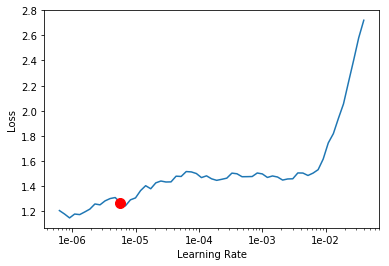

In [53]:
learn.unfreeze()
# learn.lr_find() #<-- uncomment to determine the learning rate (commented to reduce time)
# learn.recorder.plot(suggestion=True) 

In [55]:
from fastai.callbacks import SaveModelCallback

In [ ]:
learn.fit_one_cycle(18,1e-5,callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_metrics()

In [22]:
learn.save(SAVE_NAME)
learn.export()

## Inference and Submission Generation

Let's now load our test csv and process the DataFrame like we did for the training data.

In [10]:
test_df = pd.read_csv(DATA/'test.csv')
proc_test_df = generate_df(test_df.copy(),sample_num=1)

We add the data to our DataBunch:

In [25]:
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=DATA/'test/')
learn.data.add_test(data_test)

Now we can get out predictions on the test set.

In [ ]:
preds, _ = learn.get_preds(DatasetType.Test)

In [ ]:
preds_ = preds.argmax(dim=-1)

In [27]:
test_df.head(10)

,id_code,experiment,plate,well
0,HEPG2-08_1_B03,HEPG2-08,1,B03
1,HEPG2-08_1_B04,HEPG2-08,1,B04
2,HEPG2-08_1_B05,HEPG2-08,1,B05
3,HEPG2-08_1_B06,HEPG2-08,1,B06
4,HEPG2-08_1_B07,HEPG2-08,1,B07
5,HEPG2-08_1_B08,HEPG2-08,1,B08
6,HEPG2-08_1_B09,HEPG2-08,1,B09
7,HEPG2-08_1_B10,HEPG2-08,1,B10
8,HEPG2-08_1_B11,HEPG2-08,1,B11
9,HEPG2-08_1_B12,HEPG2-08,1,B12


Let's open the sample submission file and load it with our predictions to create a submission.

In [27]:
submission_df = pd.read_csv(DATA/'sample_submission.csv')

In [ ]:
submission_df.sirna = preds_.numpy().astype(int)
print(submission_df.head(5))

In [30]:
submission_df.to_csv('submission.csv',index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 